# Do the ETL

In [19]:
import boto3
from bs4 import BeautifulSoup
import pandas as pd
import hashlib

# Read from DB

In [20]:
from boto3.dynamodb.conditions import Attr
from datetime import datetime, timedelta
import time

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('tpb-top100-ts')

all_items = []
response = table.scan()
all_items.extend(response['Items'])
while 'LastEvaluatedKey' in response:
    response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
    all_items.extend(response['Items'])

In [21]:
df = pd.DataFrame(all_items)
df

,uid,data,timestamp
0,5d92b7e96fae8d77dfc675f464304633,"{'leech': 73, 'uid': '5d92b7e96fae8d77dfc675f4...",1701720000
1,44bd46650fd64ebb61cad124fe9c02b5,"{'leech': 35, 'uid': '44bd46650fd64ebb61cad124...",1701216000
2,1b92befb430e65e5731b864cbc5eda5e,"{'leech': 90, 'uid': '1b92befb430e65e5731b864c...",1701720000
3,468dfd07de4f7eca754fee1566863b3b,"{'leech': 143, 'uid': '468dfd07de4f7eca754fee1...",1701489600
4,034bfce6a7510fecbf0c4f8e8990487c,"{'leech': 127, 'uid': '034bfce6a7510fecbf0c4f8...",1701331200
...,...,...,...
6395,4ec9f2c1991220a3ffa7223e55f21869,"{'leech': 232, 'uid': '4ec9f2c1991220a3ffa7223...",1701331200
6396,2c4038eade911d37806c22a538de39dd,"{'leech': 318, 'uid': '2c4038eade911d37806c22a...",1701259200
6397,08e21c152b7860b26a227b780744e219,"{'leech': 177, 'uid': '08e21c152b7860b26a227b7...",1701676800
6398,cd01aa666e651b1b1d8839cdeef91770,"{'leech': 212, 'uid': 'cd01aa666e651b1b1d8839c...",1701921600


In [22]:
df_analysis = pd.DataFrame.from_records(df['data']).sort_values(['timestamp', 'seed'], ascending=False)

df_analysis

,leech,uid,torrent_url,type_b,type_a,seed,megabytes,uploaded,title,icons,user,timestamp
6017,950,3e120b7ea807277326c15ca29c2af8be,https://thepiratebay.org/description.php?id=74...,HD TV-Shows,Video,2123,426,2023-12-04,Family Guy S22E08 1080p WEB h264-BAE,"[icon-magnet, vip]",jajaja,1701921600
2638,832,252d3ed8c19d2cc1cffe8092e90c75a8,https://thepiratebay.org/description.php?id=73...,HD Movies,Video,1205,2068,2023-11-08,Oppenheimer.2023.1080p.BluRay.DD5.1.x264-GalaxyRG,"[icon-magnet, vip]",GalaxyRG,1701921600
1659,460,bbd2271d9c5dfa871319502f884b4a2c,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,1184,1372,2023-11-27,Rick.and.Morty.S07E07.1080p.WEB.H264-Industrio...,"[icon-magnet, vip]",TGxGoodies,1701921600
3774,20,b4b99529d1d7fd96221f81216baf901a,https://thepiratebay.org/description.php?id=12...,Windows,Applications,955,2263,2015-09-27,MICROSOFT Office PRO Plus 2016 v16.0.4266.1003...,"[icon-magnet, vip]",ThumperTM,1701921600
2584,664,d68a006d3187e2585616188a6e2f023e,https://thepiratebay.org/description.php?id=73...,HD TV-Shows,Video,880,1361,2023-11-20,Rick.and.Morty.S07E06.1080p.WEB.H264-NHTFS[TGx],"[icon-magnet, vip]",TGxGoodies,1701921600
...,...,...,...,...,...,...,...,...,...,...,...,...
5120,477,eca56620fbfeaa5e0f65ccaae7257dbb,https://thepiratebay.org/description.php?id=32...,HD TV-Shows,Video,51,42076,2019-05-17,The.Big.Bang.Theory.2007.COMPLETE.SERIES.720p....,"[icon-magnet, vip]",sotnikam,1701014400
2205,368,c20fdda30f393fd750fe7394b687e21d,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,49,114155,2020-10-01,Game.of.Thrones.Season.1-8.S01-08.COMPLETE.108...,"[icon-magnet, vip]",Cybotage,1701014400
1525,587,f41d250fd26a4f687c15bc9ea616a777,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,173537,2020-09-30,Friends (1994) Season 1-10 S01-S10 (1080p BluR...,"[icon-magnet, vip]",Cybotage,1701014400
4571,441,deec147c50dab1c350d4ca1f4206eb81,https://thepiratebay.org/description.php?id=36...,HD TV-Shows,Video,28,99307,2020-10-01,How I Met Your Mother (2005) Season 1-9 S01-S0...,"[icon-magnet, vip]",Cybotage,1701014400


In [48]:
df_analysis['timestamp'] = pd.to_datetime(df_analysis.timestamp.astype(int)*10**9)

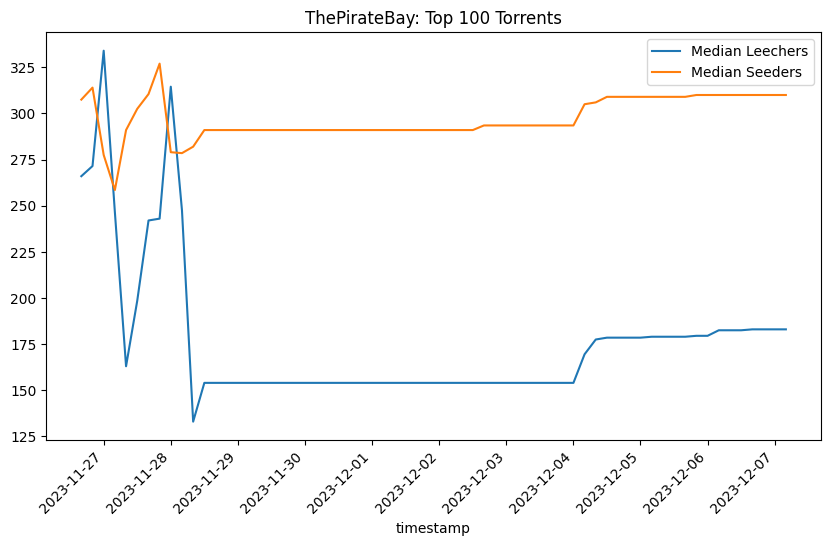

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10,6))
df_analysis.groupby('timestamp').leech.median().plot(label='Median Leechers')
df_analysis.groupby('timestamp').seed.median().plot(label='Median Seed')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # setting xticks for every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # formatting xticks as 'YYYY-MM-DD'
plt.legend(loc='best')
plt.title('ThePirateBay: Top 100 Torrents')
plt.xticks(rotation=45)  # rotating xticks for better visibility
plt.show()
